In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import grequests

##### Creating the legitimate urls

In [3]:
address=[]
status=[]
for i in range(5000):
    address.append('http://127.0.0.1:5000/safe/{:}/page?id={:}'.format(i,i))
    status.append(0)
    address.append('http://127.0.0.1:5000/vulnerable/{:}/page?id={:}'.format(i,i))
    status.append(1)
    
    
result_dict={'urls': address, 'status': status}
results = pd.DataFrame(result_dict)
results.head()

,urls,status
0,http://127.0.0.1:5000/safe/0/page?id=0,0
1,http://127.0.0.1:5000/vulnerable/0/page?id=0,1
2,http://127.0.0.1:5000/safe/1/page?id=1,0
3,http://127.0.0.1:5000/vulnerable/1/page?id=1,1
4,http://127.0.0.1:5000/safe/2/page?id=2,0


In [4]:
############################### preparing the urls for attaacking ######################################################
results['address_to_attack'] ='aaa'

for j, i in enumerate(results.urls):
    address=i
    add_to_att = address.replace(address[address.rfind('?id='):],'?id=SLEEP(5)')
    results.at[j, 'address_to_attack']= add_to_att

#### all the functions

In [20]:
########################### plotting the probability density distribution and actual data #############################
def plott_pdf(pdf_f , x ):
    fig1 = plt.figure(figsize=(10,5))
    ax1 = fig1.add_subplot(111)
    line1 = ax1.hist(x, bins=80)
    plt.ylabel("real regular respond times")

    x = np.linspace(pdf_f.ppf(0.01), pdf_f.ppf(0.99), 100)
    ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
    line2 = ax2.plot(x, pdf_f.pdf(x), 'r-', lw=5, alpha=0.6, label='chi2 pdf')
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    plt.ylabel("Probability density Distribution Function")
    
    plt.show()

################################# creating unsent pool of requests  #################################################### 
def pool_requesting(address_urls, i,j):
    
    unsentrequests = (grequests.get(u) for u in address_urls[i:j])
    response_list = grequests.map(unsentrequests)
    response_final=[]
    for response in response_list:
        response_final.append([response.url, response.elapsed.total_seconds()])   
    response_time_result= pd.DataFrame(response_final, columns=['urls', 'duration']) 
    
    return response_time_result 

def pool_requesting_multiple(address_urls, i,j, how_many_times):
    
    respond_1= pool_requesting(address_urls, i,j)
    columns_list =['duration']
    for i in range(how_many_times-1):
        column_name = 'duration_%s'%(i+2)
        columns_list.append(column_name)
        respond_temp = pool_requesting(address_urls, i,j)
        respond_1[column_name] = respond_temp['duration'].copy(deep=True)
      
    respond_1['duration_f'] = respond_1[columns_list].min(axis=1)
    respond_1.drop(columns_list, axis=1, inplace=True)
    return respond_1
    

######### predicting based on each pdf (difference b.t. before and after attacking && response time after attack) #######  
def is_regular_time(x, pdf_func, Confidence_interval):
    probability = pdf_func.cdf(x)[0]
    if probability<= Confidence_interval:
        return True
    else:
        return False

#############  status calculator for predicting based on difference b.t. before and after attacking   ##################    
def status_calculator(x, confidence_interval, pdf_func):
    y = pd.DataFrame(np.zeros((len(x),1)))
    for i in range(len(x)):
        if is_regular_time(x.loc[i], pdf_func, confidence_interval):
            y.at[i] = 0
        else:
            y.at[i] = 1
    return y      

######################################## reporting the results #########################################################
def report_result(predicted,target):
    false_positive = 0
    false_negetive = 0
    diff = predicted - target
    for i in diff:
        if i == 1:
            false_positive += 1
        elif i == -1:
            false_negetive += 1
    return  false_positive, false_negetive

####################################### plotting scatters   #############################################################
def my_plot_scatter(y):
    plt.figure(figsize=(10,6))
    plt.grid(color='r', linestyle='-', linewidth=0.5)
    x= np.arange(0,len(y),1)
    plt.scatter(x, y, c='g')
    plt.show()


#### sending requests for regular urls and attacking

In [37]:
regular_time_response  = pool_requesting_multiple(results.urls, 0, 1000, 2)
regular_time_response_2 = pool_requesting_multiple(results.urls, 0, 1000, 2)
regular_time_response_2.rename(columns={'duration_f': 'second_regular_duration'}, inplace=True)
regular_time_response= regular_time_response.merge(regular_time_response_2, on='urls', how='left')
regular_time_response['diff_regular'] =regular_time_response['duration_f'] -regular_time_response['second_regular_duration']
regular_time_response.drop('second_regular_duration', axis=1, inplace=True)


In [22]:
attacked_time_response = pool_requesting_multiple(results.address_to_attack, 1000, 2000, 2)
attacked_time_response.rename(columns={'urls': 'address_to_attack', 'duration_f': 'attacked_duration'}, inplace=True

In [26]:
data_to_train= pd.merge(regular_time_response, results, on='urls', how='left')  ### adding attacked urls & status
data_to_train = data_to_train.merge(attacked_time_response, on='address_to_attack', how='left') ### adding attacked duration
data_to_train['diff_attack_regular'] = data_to_train['attacked_duration'] - data_to_train['duration_f']

In [29]:

# data_to_train.to_excel(r'D:\Python Projects\Detectify\f_data_2.xlsx')
# data_to_train = pd.read_excel(r'D:\Python Projects\Detectify\f_data.xlsx')


#### probability density distributions

In [30]:
#######################  probability density distribution for response time after attack ###############################
df_response_regular = data_to_train[['duration_f']].mean() + 1.1
chi_pdf_response_regular= stats.chi2(df_response_regular)

####################  probability density distribution for difference b.t. before and after attacking ##################
mu = data_to_train[['diff_regular']].mean() 
std= data_to_train[['diff_regular']].std()
var = std * std
normal_pdf_diff_response= stats.norm(0, var)

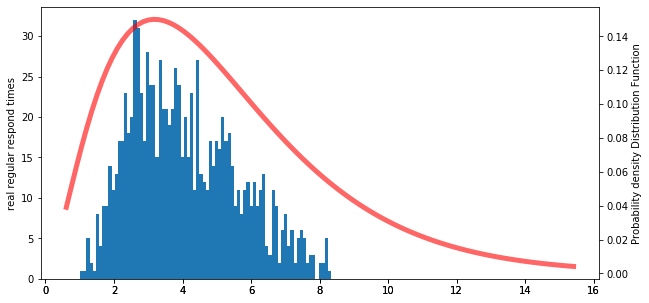

In [32]:
plott_pdf(chi_pdf_response_regular , data_to_train.duration_f)

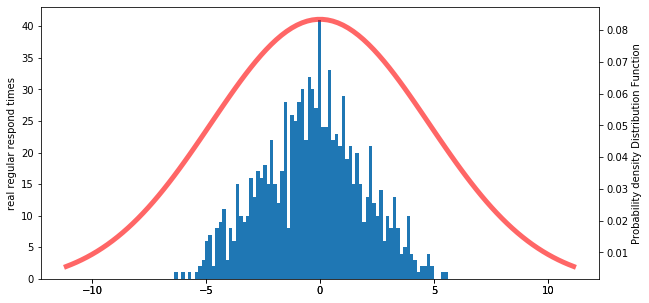

In [33]:
plott_pdf(normal_pdf_diff_response , data_to_train.diff_regular)

#### defining the predicted status

In [34]:
confidence_interval=0.78

data_to_train['Pred_status_time_res'] = status_calculator(data_to_train.attacked_duration,
                                                          confidence_interval,
                                                          chi_pdf_response_regular)

data_to_train['Pred_status_diff_time'] = status_calculator(data_to_train.diff_attack_regular,
                                                          confidence_interval,
                                                          normal_pdf_diff_response)

data_to_train[['status','Pred_status_time_res', 'Pred_status_diff_time']].head()

,status,Pred_status_time_res,Pred_status_diff_time
0,0,0.0,0.0
1,1,1.0,1.0
2,0,0.0,0.0
3,1,1.0,1.0
4,0,0.0,0.0


In [87]:
data_to_train.to_excel(r'D:\Python Projects\Detectify\ff_data.xlsx')
# FP_response_time, FN_response_time = report_result(data_to_train.Pred_status_time_res,data_to_train.status)
# FP_diff_time, FN_diff_time = report_result(data_to_train.Pred_status_diff_time,data_to_train.status)

In [36]:
result_dict ={'false positive response time method': FP_response_time,
             'false negetive response time methos': FN_response_time,
             'false positive difference attack and regular time': FP_diff_time,
             'false negetive difference attack and regular time': FN_diff_time}
final_comparison = pd.DataFrame(result_dict, index=['valus'])
final_comparison

,false positive response time method,false negetive response time methos,false positive difference attack and regular time,false negetive difference attack and regular time
valus,0,0,1,0


- so, considering the results of the two probability density it seems that chi2 pdf has better performance
----> so we use chi2 function in order to predict new urls' status

### attacking new urls based on chi2

In [70]:
test_data = results[1000:2000]
test_rsponse_time = pool_requesting_multiple(test_data.address_to_attack, 0, 1000, 2)
test_rsponse_time.head()

,urls,duration_f
0,http://127.0.0.1:5000/safe/500/page?id=SLEEP(5),3.501815
1,http://127.0.0.1:5000/vulnerable/500/page?id=S...,29.365138
2,http://127.0.0.1:5000/safe/501/page?id=SLEEP(5),4.417279
3,http://127.0.0.1:5000/vulnerable/501/page?id=S...,28.864906
4,http://127.0.0.1:5000/safe/502/page?id=SLEEP(5),3.821784


C:\ProgramData\Anaconda3\lib\site-packages\gevent\hub.py:154: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [71]:
test_rsponse_time.rename(columns={'urls': 'address_to_attack'}, inplace=True)
test_rsponse_time_2=test_rsponse_time.merge(test_data, on='address_to_attack', how='left')
test_rsponse_time_2.head()

,address_to_attack,duration_f,urls,status
0,http://127.0.0.1:5000/safe/500/page?id=SLEEP(5),3.501815,http://127.0.0.1:5000/safe/500/page?id=500,0
1,http://127.0.0.1:5000/vulnerable/500/page?id=S...,29.365138,http://127.0.0.1:5000/vulnerable/500/page?id=500,1
2,http://127.0.0.1:5000/safe/501/page?id=SLEEP(5),4.417279,http://127.0.0.1:5000/safe/501/page?id=501,0
3,http://127.0.0.1:5000/vulnerable/501/page?id=S...,28.864906,http://127.0.0.1:5000/vulnerable/501/page?id=501,1
4,http://127.0.0.1:5000/safe/502/page?id=SLEEP(5),3.821784,http://127.0.0.1:5000/safe/502/page?id=502,0


In [84]:
confidence_interval = 0.77
test_rsponse_time_2['Pred_status_time_res'] = status_calculator(test_rsponse_time_2.duration_f,
                                                          confidence_interval,
                                                          chi_pdf_response_regular)
test_rsponse_time_2.head()

,address_to_attack,duration_f,urls,status,Pred_status_time_res
0,http://127.0.0.1:5000/safe/500/page?id=SLEEP(5),3.501815,http://127.0.0.1:5000/safe/500/page?id=500,0,0.0
1,http://127.0.0.1:5000/vulnerable/500/page?id=S...,29.365138,http://127.0.0.1:5000/vulnerable/500/page?id=500,1,1.0
2,http://127.0.0.1:5000/safe/501/page?id=SLEEP(5),4.417279,http://127.0.0.1:5000/safe/501/page?id=501,0,0.0
3,http://127.0.0.1:5000/vulnerable/501/page?id=S...,28.864906,http://127.0.0.1:5000/vulnerable/501/page?id=501,1,1.0
4,http://127.0.0.1:5000/safe/502/page?id=SLEEP(5),3.821784,http://127.0.0.1:5000/safe/502/page?id=502,0,0.0


In [85]:
FP, FN = report_result(test_rsponse_time_2.Pred_status_time_res,test_rsponse_time_2.status)

print ('------------'*10)
print('false positive amount equals to %d' % FP)
print('false negetive amount equals to %d' % FN)
print ('------------'*10)

------------------------------------------------------------------------------------------------------------------------
false positive amount equals to 0
false negetive amount equals to 0
------------------------------------------------------------------------------------------------------------------------


In [86]:
test_rsponse_time_2.to_excel(r'D:\Python Projects\Detectify\test_results.xlsx')